## Import Data

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random

In [2]:
train = pd.read_csv('data_fix.csv')
train.head()

,Unnamed: 0,label,tweet
0,0,love,!rp hai ele. Maaf ya gua ga romantis. Gua cuma...
1,1,anger,"""Mka.a jgn ngatain org klu gmau dikatain...jag..."
2,2,joy,# CONGRATULATIONS # Mengucapkan selamat untuk ...
3,3,joy,#Allhamdulilah Bertambah usia lagi jagoan keci...
4,4,sadness,"#Bali, tunggu koko lagi ya. Koko bakal balik l..."


In [3]:
# Shuffle the rows
train = train.sample(frac=1).reset_index(drop=True)

print(train)

       Unnamed: 0    label                                              tweet
0            5878    anger  Saya telah mengambil untuk menghentikan pendar...
1             898     fear  aku takut acc ke suspend atuh lah jangan sampe...
2            2825     fear  Momen di mana kamu merasa seperti segala sesua...
3             993      joy  Apa yang allah berikan adalah yang terbaik unt...
4           14676  sadness  Saya bisa berada di tumpukan lumpur, Anda dapa...
...           ...      ...                                                ...
18912        6874     fear  Saya merasa bahwa guru pembimbing saya kewalah...
18913       13492     love  Saya merasakan rasa sakit yang manis dan keing...
18914        7546     fear  Saya selalu merasa terintimidasi oleh orang la...
18915        6883     fear   Saya merasa bermanifestasi dengan cara yang aneh
18916        8009      joy  saya telah telah berjuang akhir-akhir ini seti...

[18917 rows x 3 columns]


In [4]:
train = train[["label", "tweet"]]
train

,label,tweet
0,anger,Saya telah mengambil untuk menghentikan pendar...
1,fear,aku takut acc ke suspend atuh lah jangan sampe...
2,fear,Momen di mana kamu merasa seperti segala sesua...
3,joy,Apa yang allah berikan adalah yang terbaik unt...
4,sadness,"Saya bisa berada di tumpukan lumpur, Anda dapa..."
...,...,...
18912,fear,Saya merasa bahwa guru pembimbing saya kewalah...
18913,love,Saya merasakan rasa sakit yang manis dan keing...
18914,fear,Saya selalu merasa terintimidasi oleh orang la...
18915,fear,Saya merasa bermanifestasi dengan cara yang aneh


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18917 entries, 0 to 18916
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   18917 non-null  object
 1   tweet   18917 non-null  object
dtypes: object(2)
memory usage: 295.7+ KB


In [6]:
train.describe()

,label,tweet
count,18917,18917
unique,5,18387
top,joy,Aku merasa seperti aku harus melepaskan rasa m...
freq,5987,5


In [7]:
train.describe(include="O")

,label,tweet
count,18917,18917
unique,5,18387
top,joy,Aku merasa seperti aku harus melepaskan rasa m...
freq,5987,5


In [8]:
train.groupby(by="label").count()

,tweet
label,
anger,2991
fear,2588
joy,5987
love,1859
sadness,5492


In [9]:
train['num_label'] = train['label'].map({'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4})
train.head()

,label,tweet,num_label
0,anger,Saya telah mengambil untuk menghentikan pendar...,0
1,fear,aku takut acc ke suspend atuh lah jangan sampe...,1
2,fear,Momen di mana kamu merasa seperti segala sesua...,1
3,joy,Apa yang allah berikan adalah yang terbaik unt...,2
4,sadness,"Saya bisa berada di tumpukan lumpur, Anda dapa...",4


## Data Preprocessing

In [10]:
# !pip install emoji
# !pip install python-crfsuite

In [11]:
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import CRFTagger

In [12]:
text = "Woi, hari ini gue sama pacar lagi hangout di mall, abis makan bareng trus jalan-jalan seru-seruan. Gue senyum-senyum sendiri liat dia, rasanya bener-bener bahagia banget deh! Trus kita foto-foto bareng, lumayan buat kenang-kenangan. Pas pulang, gue peluk dia dari belakang, rasanya pengen nggak lepas, kayaknya waktu berhenti sebentar aja. Hari yang indah banget, apalagi sama dia"

In [13]:
def lowercase(review):
    return review.lower() #dari python langsung, bkn dari external library
# hapus URL
def remove_url(review):
    return re.sub(r'http\S+', '', review)
# hapus irrelevant char(angka, simbol, tanda baca)
def remove_irrelevant(review):
    return re.sub('[^a-zA-Z\s]', ' ', review)
# hapus spasi lebih dari 1
def remove_space(review):
    review= re.sub(r'\s+', ' ', review)
    review= review.replace('\n', ' ')
    review= review.replace('\\n', ' ')
    review= review.replace('\t', ' ')
    review= review.replace('\\t', ' ')
    review= review.replace('\\u', ' ')
    review= review.replace('\\', ' ')
    return review

# hapus emoji
def remove_emoji(review):
    emoji_pattern= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticon
                           u"\U0001F300-\U0001F5FF"  # simbol & dingbat
                           u"\U0001F680-\U0001F6FF"  # transportasi & simbol map
                           u"\U0001F700-\U0001F77F"  # simbol kuno
                           u"\U0001F780-\U0001F7FF"  # simbol kuno tambahan
                           u"\U0001F800-\U0001F8FF"  # simbol tanda batas
                           u"\U0001F900-\U0001F9FF"  # emoticon tambahan
                           u"\U0001FA00-\U0001FA6F"  # simbol musik
                           u"\U0001FA70-\U0001FAFF"  # simbol musik tambahan
                           u"\U00002702-\U000027B0"  # simbol karakter
                           u"\U000024C2-\U0001F251"  # simbol katakter tambahan
                           "]+", flags= re.UNICODE)
    return emoji_pattern.sub(r'', review)


#REMOVING REPEAT CHARACTER
def repeat_char(review):
    review= re.sub('([A-Za-z])\\1{2,}','\\1', review)
    return review


#STOPWORD ENGLISH --> NEED TO FIX
def remove_stopwords(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (string): sentence to remove the stopwords from

    Returns:
        sentence (string): lowercase sentence without the stopwords
    """
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]

    words = sentence.split()
    no_words = [w for w in words if w not in stopwords]
    sentence = " ".join(no_words)

    return sentence


In [14]:
def df_prep(train):
    train['filtering']= train['tweet'].apply(lowercase)
    train['filtering']= train['filtering'].apply(remove_url)
    train['filtering']= train['filtering'].apply(remove_irrelevant)
    train['filtering']= train['filtering'].apply(remove_space)
    train['filtering']= train['filtering'].apply(remove_emoji)
    train['filtering']= train['filtering'].apply(repeat_char)
    train["filtering"]= train["filtering"].apply(remove_stopwords)
    return train

In [15]:
train = df_prep(train)
train

,label,tweet,num_label,filtering
0,anger,Saya telah mengambil untuk menghentikan pendar...,0,saya telah mengambil untuk menghentikan pendar...
1,fear,aku takut acc ke suspend atuh lah jangan sampe...,1,aku takut acc ke suspend atuh lah jangan sampe...
2,fear,Momen di mana kamu merasa seperti segala sesua...,1,momen di mana kamu merasa seperti segala sesua...
3,joy,Apa yang allah berikan adalah yang terbaik unt...,2,apa yang allah berikan adalah yang terbaik unt...
4,sadness,"Saya bisa berada di tumpukan lumpur, Anda dapa...",4,saya bisa berada di tumpukan lumpur anda dapat...
...,...,...,...,...
18912,fear,Saya merasa bahwa guru pembimbing saya kewalah...,1,saya merasa bahwa guru pembimbing saya kewalah...
18913,love,Saya merasakan rasa sakit yang manis dan keing...,3,saya merasakan rasa sakit yang manis dan keing...
18914,fear,Saya selalu merasa terintimidasi oleh orang la...,1,saya selalu merasa terintimidasi oleh orang la...
18915,fear,Saya merasa bermanifestasi dengan cara yang aneh,1,saya merasa bermanifestasi dengan cara yang aneh


In [16]:
train_split = 0.8
train_size = int(len(train['filtering'])*train_split)
train_size

15133

In [17]:
traindata = train[0:train_size]
valdata = train[train_size:]

In [18]:
traindata

,label,tweet,num_label,filtering
0,anger,Saya telah mengambil untuk menghentikan pendar...,0,saya telah mengambil untuk menghentikan pendar...
1,fear,aku takut acc ke suspend atuh lah jangan sampe...,1,aku takut acc ke suspend atuh lah jangan sampe...
2,fear,Momen di mana kamu merasa seperti segala sesua...,1,momen di mana kamu merasa seperti segala sesua...
3,joy,Apa yang allah berikan adalah yang terbaik unt...,2,apa yang allah berikan adalah yang terbaik unt...
4,sadness,"Saya bisa berada di tumpukan lumpur, Anda dapa...",4,saya bisa berada di tumpukan lumpur anda dapat...
...,...,...,...,...
15128,anger,Saya terus menangis atau merasa rewel,0,saya terus menangis atau merasa rewel
15129,sadness,Dan gitarku yang dipinjam teman belum dikembal...,4,dan gitarku yang dipinjam teman belum dikembal...
15130,joy,Saya bisa merasakan semangatnya yang manis dan...,2,saya bisa merasakan semangatnya yang manis dan...
15131,joy,Saya kagum dengan apa yang saya miliki dan say...,2,saya kagum dengan apa yang saya miliki dan say...


In [19]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
max_length = 1000

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')

# Generate the word index dictionary
tokenizer.fit_on_texts(traindata['filtering'])
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(traindata['filtering'])
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the validation sequences
validation_sequences = tokenizer.texts_to_sequences(valdata['filtering'])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Build Model

In [20]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(5000, 16, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


C:\Users\DAFA\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
'''
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(17000, 64, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
'''

"\nmodel = tf.keras.Sequential([\n    tf.keras.layers.Embedding(17000, 64, input_length=max_length),\n    tf.keras.layers.GlobalAveragePooling1D(),\n    tf.keras.layers.Dense(128, activation='relu'),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(1, activation='sigmoid')\n])\n"

In [22]:
'''
# Build the model
model = tf.keras.Sequential([
    # This is how you need to set the Embedding layer when using pre-trained embeddings
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

# Print the model summary
model.summary()
'''

'\n# Build the model\nmodel = tf.keras.Sequential([\n    # This is how you need to set the Embedding layer when using pre-trained embeddings\n    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, weights=[embeddings_matrix], trainable=False),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),\n    tf.keras.layers.Dropout(0.2),\n    tf.keras.layers.Dense(6, activation = \'relu\'),\n    tf.keras.layers.Dense(1, activation = "sigmoid")\n])\n\n# Print the model summary\nmodel.summary()\n'

In [23]:
'''
model = tf.keras.Sequential([
     tf.keras.layers.Embedding(17000, 32, input_length=max_length),
     tf.keras.layers.Dropout(0.2),  # Add dropout layer
     tf.keras.layers.GlobalAveragePooling1D(),
     tf.keras.layers.Dense(16, activation='relu'),  # Reduced number of units
     tf.keras.layers.Dropout(0.2),  # Add dropout layer
     tf.keras.layers.Dense(5, activation='softmax')
 ])
'''

"\nmodel = tf.keras.Sequential([\n     tf.keras.layers.Embedding(17000, 32, input_length=max_length),\n     tf.keras.layers.Dropout(0.2),  # Add dropout layer\n     tf.keras.layers.GlobalAveragePooling1D(),\n     tf.keras.layers.Dense(16, activation='relu'),  # Reduced number of units\n     tf.keras.layers.Dropout(0.2),  # Add dropout layer\n     tf.keras.layers.Dense(5, activation='softmax')\n ])\n"

In [24]:
from tensorflow.keras.optimizers import Adam
# Define the learning rate
#learning_rate = 0.001

# Compile the model with Adam optimizer and specified learning rate

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])


In [25]:
num_epochs = 1

# Train the model
history = model.fit(training_padded, traindata['num_label'], epochs=num_epochs, validation_data=(validation_padded, valdata['num_label']), verbose=2)

C:\Users\DAFA\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


473/473 - 5s - 11ms/step - accuracy: 0.3091 - loss: 1.5181 - val_accuracy: 0.2859 - val_loss: 1.5267


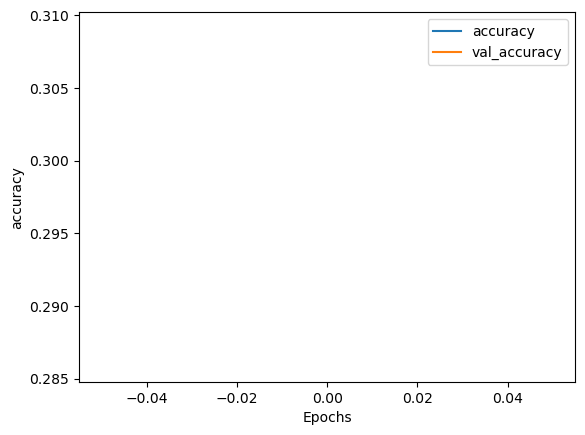

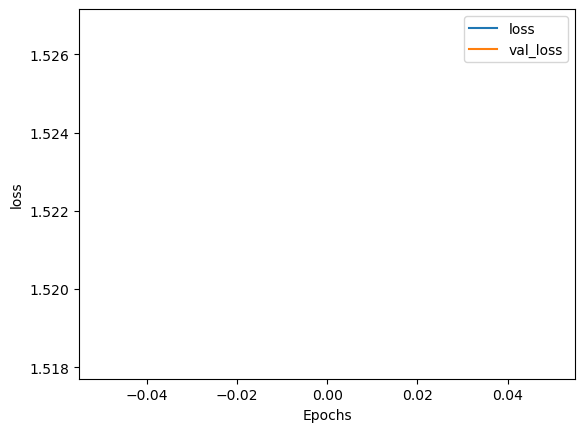

In [26]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Predicting

In [27]:
text = "Woi, hari ini gue sama pacar lagi hangout di mall, abis makan bareng trus jalan-jalan seru-seruan. Gue senyum-senyum sendiri liat dia, rasanya bener-bener bahagia banget deh! Trus kita foto-foto bareng, lumayan buat kenang-kenangan. Pas pulang, gue peluk dia dari belakang, rasanya pengen nggak lepas, kayaknya waktu berhenti sebentar aja. Hari yang indah banget, apalagi sama dia"

In [28]:
#data test preprocessing

def prep_test(review):
    review = lowercase(review)
    review = remove_url(review)
    review = remove_irrelevant(review)
    review = remove_space(review)
    review = remove_emoji(review)
    review = repeat_char(review)
    text = [review]
    inference_sequences = tokenizer.texts_to_sequences(text)
    inference_padded = pad_sequences(inference_sequences, padding=padding_type, maxlen=max_length)
    return inference_padded

In [29]:
test_padded = prep_test(text)

In [30]:
def prediction(test):
    label = ["anger", "fear", "joy", "love", "sadness"]
    result = model.predict(test)
    index = np.argmax(result)
    hasil = label[index]
    return hasil

In [31]:
prediction(test_padded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


'sadness'

# SAVE & CONVERT

In [ ]:
export_dir = 'saved_model/1'

# Load the SavedModel
loaded_model = tf.saved_model.load(export_dir)

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
tflite_model_file = 'converted_model.tflite'
with open(tflite_model_file, 'wb') as f:
    f.write(tflite_model)

print(f'TensorFlow Lite model saved to {tflite_model_file}')